In [7]:
#Importing libraries and tools
import os
import numpy as np
import random
from PIL import Image, ImageEnhance
import matplotlib.pyplot as plt

from tensorflow.keras import Sequential
from tensorflow.keras.layers import Input, Dense, Flatten, Dropout, BatchNormalization
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import VGG16
from sklearn.utils import shuffle

In [8]:
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json


In [9]:
!pip install -q kaggle

In [10]:
!kaggle datasets download -d masoudnickparvar/brain-tumor-mri-dataset

Dataset URL: https://www.kaggle.com/datasets/masoudnickparvar/brain-tumor-mri-dataset
License(s): CC0-1.0
 82% 122M/149M [00:00<00:00, 406MB/s] 
100% 149M/149M [00:00<00:00, 439MB/s]


In [11]:
!unzip -q brain-tumor-mri-dataset.zip -d brain_tumor_dataset

In [12]:
#Getting the directories for the training and testing data
train_dir = '/content/brain_tumor_dataset/Training'
test_dir = '/content/brain_tumor_dataset/Testing'

#Load and shuffle the training data
train_paths = []
train_labels = []

for label in os.listdir(train_dir):
      for image in os.listdir(os.path.join(train_dir, label)):
            train_paths.append((os.path.join(train_dir, label, image), label))
            train_labels.append(label)

train_paths, train_labels = shuffle(train_paths, train_labels, random_state=42)

#Load and shuffle the testing data
test_paths = []
test_labels = []

for label in os.listdir(test_dir):
      for image in os.listdir(os.path.join(test_dir, label)):
            test_paths.append((os.path.join(test_dir, label, image), label))
            test_labels.append(label)

test_paths, test_labels = shuffle(test_paths, test_labels, random_state=42)

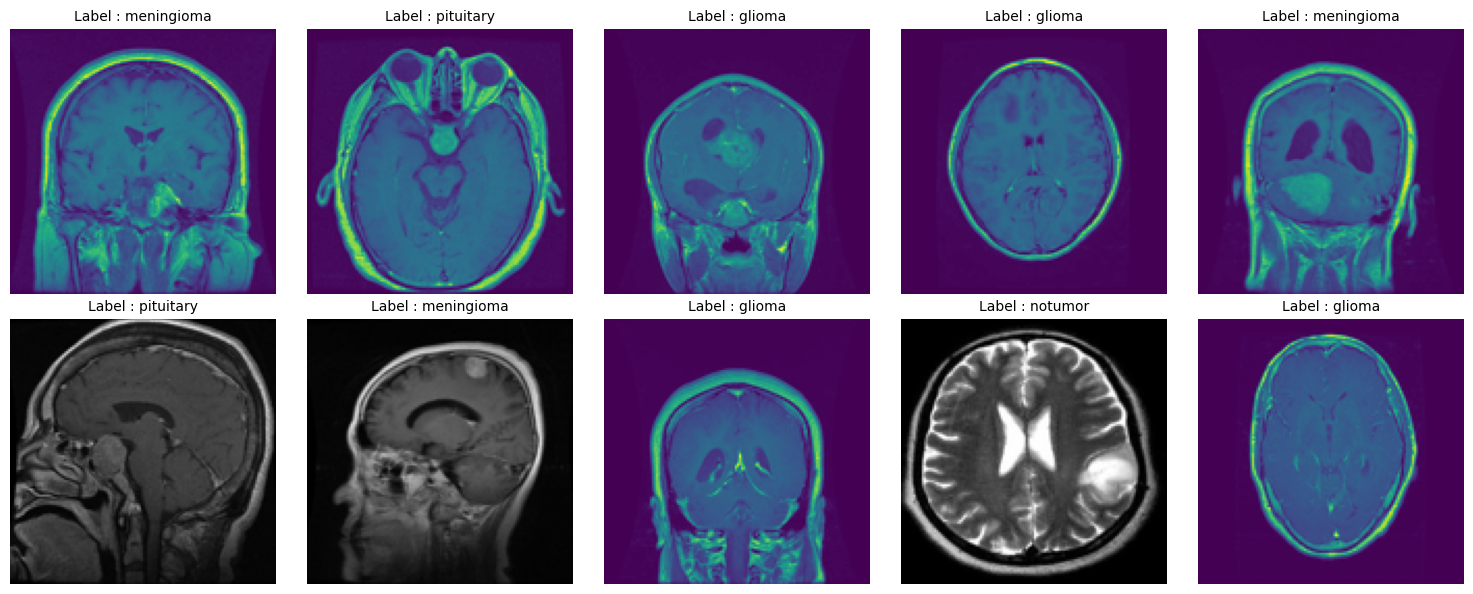

In [13]:
random_indices = random.sample(range(len(train_paths)), 10)

fig, axes = plt.subplots(2, 5, figsize=(15, 6))
axes = axes.ravel()

for i, index in enumerate(random_indices):
    image_path = train_paths[index][0]  # Corrected line: Access the first element (path)
    img = Image.open(image_path).resize((128, 128))

    axes[i].imshow(img)
    axes[i].axis('off')
    axes[i].set_title(f"Label : {train_labels[index]}", fontsize=10)

plt.tight_layout()
plt.show()

#**Image Preprocessing**

In [14]:
# Image Augmentation function
def augment_image(image):
    image = Image.fromarray(np.uint8(image))
    image = ImageEnhance.Brightness(image).enhance(random.uniform(0.8, 1.2))  # Random brightness
    image = ImageEnhance.Contrast(image).enhance(random.uniform(0.8, 1.2))  # Random contrast
    image = np.array(image) / 255.0  # Normalize pixel values to [0, 1]
    return image

# Load images and apply augmentation
def open_images(paths): # 'paths' will now be a list of actual file paths (strings)
    images = []
    for path in paths:
        image = load_img(path, target_size=(IMAGE_SIZE, IMAGE_SIZE))
        image = augment_image(image)
        images.append(image)
    return np.array(images)

# Encoding labels (convert label names to integers)
def encode_label(labels):
    unique_labels = os.listdir(train_dir)  # Ensure unique labels are determined
    encoded = [unique_labels.index(label) for label in labels]
    return np.array(encoded)

# Data generator for batching
def datagen(paths_with_labels, labels_list, batch_size=12, epochs=1): # Renamed 'paths' to 'paths_with_labels' for clarity
    for _ in range(epochs):
        for i in range(0, len(paths_with_labels), batch_size):
            batch_paths_tuples = paths_with_labels[i:i + batch_size] # This is a list of (filepath, label) tuples

            # Extract only the filepaths (the first element of each tuple)
            actual_image_paths = [path_tuple[0] for path_tuple in batch_paths_tuples]
            batch_images = open_images(actual_image_paths)  # Pass the list of actual paths

            # 'labels_list' is the original train_labels (list of strings)
            current_batch_labels_list = labels_list[i:i + batch_size]
            batch_labels_encoded = encode_label(current_batch_labels_list)  # Encode labels
            yield batch_images, batch_labels_encoded

#**Model**

In [15]:
# Model architecture
IMAGE_SIZE = 128  # Image size (adjust based on your requirements)
base_model = VGG16(input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3), include_top=False, weights='imagenet')

# Freeze all layers of the VGG16 base model
for layer in base_model.layers:
    layer.trainable = False

# Set the last few layers of the VGG16 base model to be trainable
base_model.layers[-2].trainable = True
base_model.layers[-3].trainable = True
base_model.layers[-4].trainable = True

# Build the final model
model = Sequential()
model.add(Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 3)))  # Input layer
model.add(base_model)  # Add VGG16 base model
model.add(Flatten())  # Flatten the output of the base model
model.add(Dropout(0.3))  # Dropout layer for regularization
model.add(Dense(128, activation='relu'))  # Dense layer with ReLU activation
model.add(Dropout(0.2))  # Dropout layer for regularization
model.add(Dense(len(os.listdir(train_dir)), activation='softmax'))  # Output layer with softmax activation

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='sparse_categorical_crossentropy',
              metrics=['sparse_categorical_accuracy'])

# Parameters
batch_size = 20
steps = int(len(train_paths) / batch_size)  # Steps per epoch
epochs = 5

# Train the model
history = model.fit(datagen(train_paths, train_labels, batch_size=batch_size, epochs=epochs),
                    epochs=epochs, steps_per_epoch=steps)


58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step
Epoch 1/5
285/285 ━━━━━━━━━━━━━━━━━━━━ 27s 63ms/step - loss: 0.6777 - sparse_categorical_accuracy: 0.7426
Epoch 2/5
285/285 ━━━━━━━━━━━━━━━━━━━━ 23s 65ms/step - loss: 0.2671 - sparse_categorical_accuracy: 0.8979
Epoch 3/5
285/285 ━━━━━━━━━━━━━━━━━━━━ 18s 64ms/step - loss: 0.1598 - sparse_categorical_accuracy: 0.9404
Epoch 4/5
285/285 ━━━━━━━━━━━━━━━━━━━━ 18s 64ms/step - loss: 0.1220 - sparse_categorical_accuracy: 0.9504
Epoch 5/5
285/285 ━━━━━━━━━━━━━━━━━━━━ 18s 63ms/step - loss: 0.0808 - sparse_categorical_accuracy: 0.9706


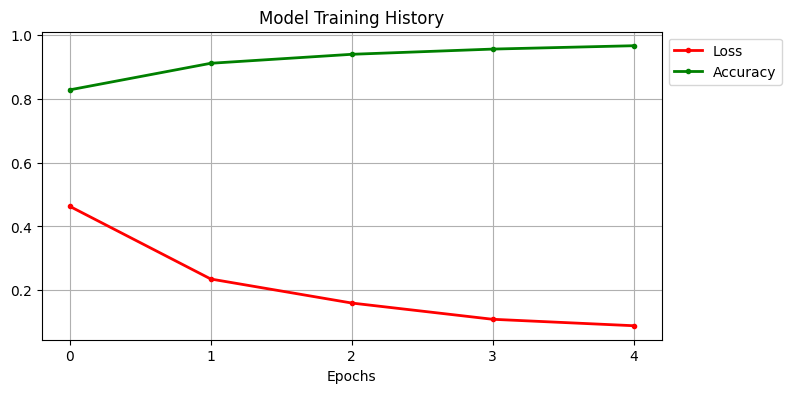

In [16]:
plt.figure(figsize = (8,4))
plt.grid(True)
plt.plot(history.history['loss'], '.r-', linewidth=2)
plt.plot(history.history['sparse_categorical_accuracy'], '.g-', linewidth=2)
plt.title('Model Training History')
plt.xlabel('Epochs')
plt.xticks([x for x in range(epochs)])
plt.legend(['Loss', 'Accuracy'], loc='upper left', bbox_to_anchor=(1,1))
plt.show()

In [17]:
# Model Classification Report
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import label_binarize
import numpy as np

# Fix test_paths if it contains (path, label) tuples
test_images = open_images([p[0] for p in test_paths])
test_labels_encoded = encode_label(test_labels)

# Predict and decode predictions
test_predictions = model.predict(test_images)
test_predictions_classes = np.argmax(test_predictions, axis=1)

print('Classification Report:')
print(classification_report(test_labels_encoded, np.argmax(test_predictions, axis = 1)))


41/41 ━━━━━━━━━━━━━━━━━━━━ 15s 220ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.93      0.94       300
           1       0.99      0.91      0.95       300
           2       0.88      0.95      0.91       306
           3       0.98      1.00      0.99       405

    accuracy                           0.95      1311
   macro avg       0.95      0.95      0.95      1311
weighted avg       0.95      0.95      0.95      1311



#**Model Confusion Plot**

[[278   0  21   1]
 [  4 274  19   3]
 [  8   2 291   5]
 [  0   0   1 404]]


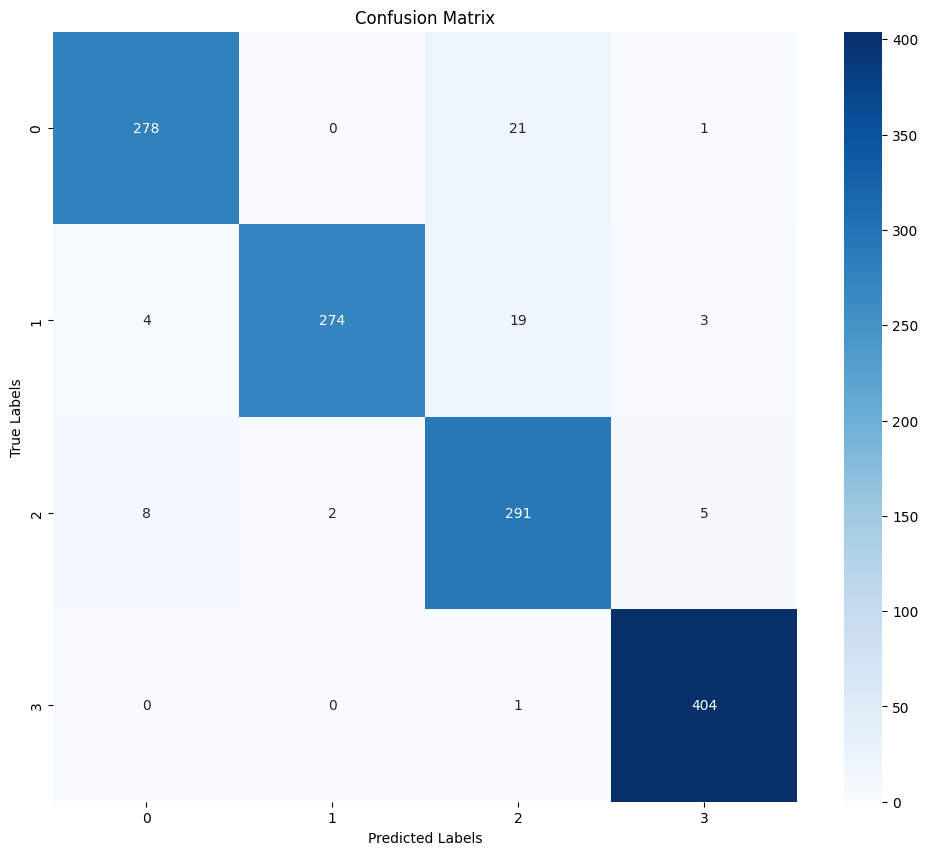

In [18]:
conf_matrix = confusion_matrix(test_labels_encoded, test_predictions_classes)
plt.figure(figsize=(12, 10))
print(conf_matrix)


sns.heatmap(conf_matrix, annot=True, fmt = 'd', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

#**Roc Curve Plot**

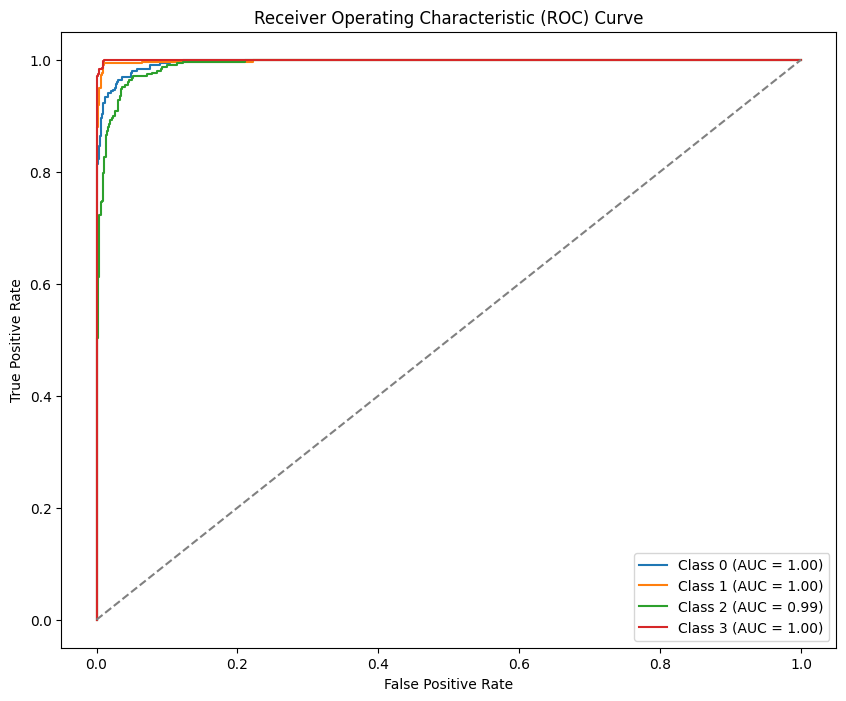

In [19]:
test_labels_bin = label_binarize(test_labels_encoded, classes=np.arange(len(os.listdir(train_dir))))
test_predictions_bin = test_predictions

#Compute ROC curve and ROC AUC for each class
fpr, tpr, roc_auc = {}, {}, {}
for i in range(len(os.listdir(train_dir))):
    fpr[i], tpr[i], _ = roc_curve(test_labels_bin[:, i], test_predictions_bin[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

#Plot ROC curve for each class
plt.figure(figsize=(10, 8))
for i in range(len(os.listdir(train_dir))):
  plt.plot(fpr[i], tpr[i], label=f'Class {i} (AUC = {roc_auc[i]:.2f})')

plt.plot([0,1], [0,1], linestyle = '--', color = 'gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc = "lower right")
plt.show()

# **Saving and load the model**

In [20]:
#Save the model
model.save('model.h5')

In [ ]:
from google.colab import drive
drive.mount('/content/drive')